In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
from pathlib import Path
import os
import copy
from torch.utils.data import DataLoader

# Magic Function
%matplotlib inline
# Hide all warnings
import warnings
warnings.filterwarnings('ignore') # warnings.filterwarnings(action='once')

# monkey-patch torchvision to work offline or behind a firewall
from pathlib import Path
model_path = Path('../../data/processed/models/resnet18-5c106cde.pth').absolute().resolve()
models.resnet.model_urls['resnet18'] = 'file://{}'.format(model_path)
model_path = Path('../../data/processed/models/resnet34-333f7ec4.pth').absolute().resolve()
models.resnet.model_urls['resnet34'] = 'file://{}'.format(model_path)

# Finetuning / Transfer Learning

Finetuning or Transfer Learning in DNNs is done by taking a pretrained model and repurposed to a new dataset. The idea behind this approach is that pretrained datasets usually provide a better starting point for training than randomly initializing a network. Therefore, it is expected that the network can converge faster when doing finetuning.

<div class="alert alert-info" style="font-size:100%">
    
**WARNING** <br/>
We recommend running this notebook only if you have a GPU available. The training code might take more than 40 minutes in a `cpu`.
</div>

Let's setup a device variable. This will allow us to automatically use a `gpu` if it is available. Otherwise, it will use `cpu`.

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Now let's create a ResNet model using pretrained weights of the [ImageNet dataset](http://www.image-net.org/).

In [3]:
model_ft = models.resnet18(pretrained=True)

Now let's check the architecture of the ResNet model

In [4]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

As can be seen in the architecture, the last layer (fc) has an input size of 512. We can also get this information programatically using the code below:

In [5]:
# Input Features
num_ftrs = model_ft.fc.in_features
print(num_ftrs)

512


In the original ResNet arquitecture, the first layer (conv1) has 3 channels in the input. The reason for that is that it accepts colored images in the RGB space. However, our dataset only contains images in gray scale. Those images only have one channel so we need to modify this in our ResNet model.

In [6]:
model_ft.conv1 = nn.Conv2d(
    1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
)

Now we need to modify the last layer. We will change the output from 1000 to match the number of classes we have in the new dataset.

In [7]:
# nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 4)

In [8]:
# Pass the model to GPU or CPU
model_ft = model_ft.to(device)
# Declare Loss Function
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# Decay learning rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Dataset

Data source: https://dataunderground.org/dataset/landmass-f3

Credits to researchers at Georgia Tech, Agile Geoscience
License CCbySA

In this notebook, we will be using the landmass dataset, which have been preprocessed already. In this dataset, we have images of 4 different types of landmass: 'Chaotic Horizon', 'Fault', 'Horizon', 'Salt Dome'.

We will finetuned a pretrained CNN to learn how to classify images of landmass into those 4 classes.

#  Data Augmentation
It is a well-known fact that current Deep Neural Networks (DNNs) are data hungry. The more examples we have for our model the better it will generalise. However, in some cases, getting more images is not a viable option. Fortunately, we can use data augmentation or image transformations to generate more images.

In Pytorch, we can use `transforms` to achieve this. Given that we are using pretrained models on ImageNet, it is important to normalize the data using the same `mean` and `std` than the one used on ImageNet. [More Information](https://pytorch.org/docs/stable/torchvision/models.html). However, in our particular case, the images used will be gray scale so we will change the normalization to work accordingly.

`transforms.Compose` will allow us to apply a sequential pipeline of transformations to your Pytorch Tensors.

In the example below, `transforms.RandomResizedCrop(224)` will resize (224x224 pixels) and crop randomly an image. `transforms.RandomHorizontalFlip()` will flip horizontally some images at random. Finally, after those two transformations the image is converted to Pytorch Tensor and the normalized.

In [9]:
data_transforms = {
    # For the data training dataset
    "train": transforms.Compose(
        [
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
            # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]
    ),
    # For the validation dataset
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
            # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]
    ),
}

In [10]:
# Let's import the Patches
from deep_ml_curriculum.data.landmass_f3 import LandmassF3PatchesMini
from deep_ml_curriculum.config import project_dir

landmassf3_train = LandmassF3PatchesMini(
    project_dir / "data/processed/landmass-f3",
    train=True,
    transform=data_transforms["train"],
)
landmassf3_test = LandmassF3PatchesMini(
    project_dir / "data/processed/landmass-f3",
    train=False,
    transform=data_transforms["val"],
)
print(landmassf3_train)
print(landmassf3_test)

Dataset LandmassF3PatchesMini
    Number of datapoints: 39750
    Root location: /media/wassname/Storage5/projects2/3ST/deep_ml_curriculum/data/processed/landmass-f3
    Split: Train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Dataset LandmassF3PatchesMini
    Number of datapoints: 13251
    Root location: /media/wassname/Storage5/projects2/3ST/deep_ml_curriculum/data/processed/landmass-f3
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


In [11]:
classes = landmassf3_train.classes
num_classes = len(classes)
print(classes)

['Chaotic Horizon', 'Fault', 'Horizon', 'Salt Dome']


In [12]:
# Parameters
params = {"batch_size": 64, "shuffle": True, "num_workers": 8}

In [13]:
dataloaders = {
    "train": DataLoader(landmassf3_train, **params),
    "val": DataLoader(landmassf3_test, **params),
}

In [14]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    dataloader = None
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:

                # print(inputs.shape, labels.shape)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == "train":
                scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase])
            epoch_acc = running_corrects.double() / len(dataloaders[phase])

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(
        "Training complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )
    print("Best val Acc: {:4f}".format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

<div class="alert alert-info" style="font-size:100%">
    
**WARNING** <br/>
The code below might take around 10 to 15 minutes to train.
</div>

In [15]:
model_ft = train_model(
    model_ft, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5
)

Epoch 0/4
----------
train Loss: 33.3754 Acc: 50.8296
val Loss: 15.6571 Acc: 57.7115

Epoch 1/4
----------
train Loss: 22.3739 Acc: 55.1495
val Loss: 9.3037 Acc: 60.3173

Epoch 2/4
----------
train Loss: 18.6588 Acc: 56.7203
val Loss: 6.8860 Acc: 61.4615

Epoch 3/4
----------
train Loss: 16.4091 Acc: 57.6495
val Loss: 5.3165 Acc: 62.0385

Epoch 4/4
----------
train Loss: 15.1004 Acc: 58.1720
val Loss: 4.4742 Acc: 62.1442

Training complete in 5m 13s
Best val Acc: 62.144231


In [16]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    dataloader_val = dataloaders['val']
    

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader_val):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title(
                    "predicted: {}".format(dataloader_val.dataset.classes[preds[j]])
                )
                plt.imshow(
                    transforms.ToPILImage()(inputs.cpu().data[j]),
                    interpolation="bicubic",
                )

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

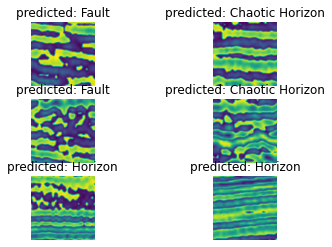

In [17]:
visualize_model(model_ft, num_images=6)

<div class="alert alert-success" style="font-size:100%">

**Exercise 1:** <br>
Repeat all the steps to apply transfer learning in a `Resnet34` model using the dataset `LandmassF3Patches`. Use `Adam` optimiser instead of `SGD`.
</div>


You can click in the button below the reveal the solution for exercise 1

<details>    
<summary>
    <font size="4" color="darkblue"><b>See the solution for Exercise 1</b></font>
</summary>
    
```python
from deep_ml_curriculum.data.landmass_f3 import LandmassF3Patches
from deep_ml_curriculum.config import project_dir

# Landmass 
landmassf3_train = LandmassF3Patches(project_dir / 'data/processed/landmass-f3', train=True, transform=data_transforms['train'])
landmassf3_test = LandmassF3Patches(project_dir / 'data/processed/landmass-f3', train=False, transform=data_transforms['val'])
# Modify Resnet34 for finetuning
model_ft = models.resnet34(pretrained=True)
model_ft.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model_ft.fc = nn.Linear(num_ftrs, 4)
model_ft = model_ft.cuda()
# Create Dataloader
dataloaders = {'train': DataLoader(landmassf3_train, **params),
               'val': DataLoader(landmassf3_test, **params)}

learning_rate = 1e-3
optimizer = torch.optim.Adam(model_ft.parameters(), lr=learning_rate)

# Train model
model_ft = train_model(model_ft, dataloaders, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=25)
```

</details>

# Sources

[Finetuning Pytorch tutorial](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)